In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from sklearn import linear_model
import h5py

In this project, we explore the Dynamic Mode Decomposition framework to attempt to predict the dynamics present in two data sets, the first of which consists of population recordings of Hare and Lynx populations in a fixed region over the course of 60 years; the measurements are taken two years apart over this period of time. This yields a matrix $\texttt{X}$ whose $k$th column has two entries, whose first and second entries are the Hare population and Lynx population that year, respectively.

The sedond data set that is used to predict dynamics is a data set consisting of 1200 images of the Belousov-Zhabotinsky chemical oscillator; each image has dimension 451 by 351, so the entire trajectory can be seen as a 3D tensor of dimension 1200 by 451 by 351. This is described in greater detail after the Lynx/Hare data is analyzed.

In [2]:
X = np.array([[20, 20, 52, 83, 64, 68, 83, 12, 36, 150, 110, 60, 7, 10, 70, 100, 92, 70, 10, 11, 137, 137, 18, 22, 52, 83, 18, 10, 9, 65], 
             [32, 50, 12, 10, 13, 36, 15, 12, 6, 6, 65, 70, 40, 9, 20, 34, 45, 40, 15, 15, 60, 80, 26, 18, 37, 50, 35, 12, 12, 35]])

We now do the first part of the assignment, i.e. evaluate Dynamic Mode Decomposition (DMD) on the given Hare/Lynx data set. This is done initially with the entire data set, giving abysmal results. Following this, we re-size the window of the DMD decomposition to take only 5 columns at a time and make a single prediction, and do so once more with 3 columns at a time. These results, while also gnot great, now intersect the plot of the data set itself, and so we are satisfied.

In [3]:
X1 = X[:, 0:29]      # entire data set DMD
X2 = X[:, 1:30]
U, s, V = np.linalg.svd(X1)
S = np.diag(s); si = 1/s; Si = np.diag(si); V = V[0:2,:]
Atilde = U.T @ X2 @ V.T @ Si
lamb, Ev = np.linalg.eig(Atilde)
Lamb = np.diag(lamb)
Phi = X2 @ V.T @ Si @ Ev
b = np.linalg.solve(Phi, X[:,0])
omega = np.log(lamb)/2
Y = np.zeros((2,30))
for ii in range(30):
    y = Phi @ np.linalg.matrix_power(Lamb, ii) @ b
    Y[:,ii] = y
Y = np.rint(Y)

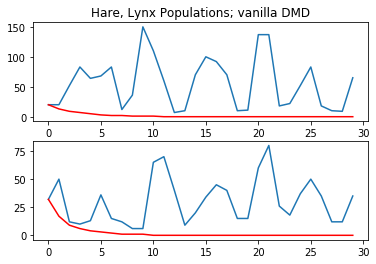

In [4]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Y[0,:], 'r')
axs[0].set_title('Hare, Lynx Populations; vanilla DMD')
axs[1].plot(X[1,:])
axs[1].plot(Y[1,:], 'r')

In [5]:
Y5 = np.zeros((2,30))  #Window size 5 DMD
Y5[:,0] = X[:,0]

for ii in range(24):
    X1 = X[:, ii+0:ii+4]
    X2 = X[:, ii+1:ii+5]
    U, s, V = np.linalg.svd(X1)
    S = np.diag(s); si = 1/s; Si = np.diag(si); V = V[0:2,:]
    Atilde = U.T @ X2 @ V.T @ Si
    lamb, Ev = np.linalg.eig(Atilde)
    Phi = X2 @ V.T @ Si @ Ev
    b = np.linalg.solve(Phi, X[:,0])
    Y5[:,ii+1]  = b[0]*Phi[:,0]*lamb[0] + b[1]*Phi[:,1]*lamb[1]
Y5 = np.rint(Y5)

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


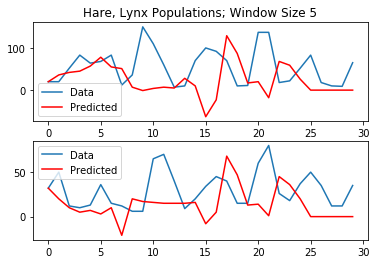

In [6]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Y5[0,:], 'r')
axs[0].set_title('Hare, Lynx Populations; Window Size 5')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(Y5[1,:], 'r')
axs[1].legend(['Data', 'Predicted'],loc=0)

In [7]:
Y3 = np.zeros((2,30))    #Window size 3 DMD
Y3[:,0] = X[:,0]

for ii in range(27):
    X1 = X[:, ii+0:ii+2]
    X2 = X[:, ii+1:ii+3]
    U, s, V = np.linalg.svd(X1)
    S = np.diag(s); si = 1/s; Si = np.diag(si); V = V[0:2,:]
    Atilde = U.T @ X2 @ V.T @ Si
    lamb, Ev = np.linalg.eig(Atilde)
    Phi = X2 @ V.T @ Si @ Ev
    b = np.linalg.solve(Phi, X[:,0])
    Y3[:,ii+1]  = b[0]*Phi[:,0]*lamb[0] + b[1]*Phi[:,1]*lamb[1]
Y3 = np.rint(Y3)

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


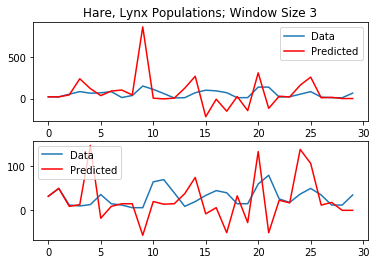

In [8]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Y3[0,:], 'r')
axs[0].set_title('Hare, Lynx Populations; Window Size 3')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(Y3[1,:], 'r')
axs[1].legend(['Data', 'Predicted'],loc=0)

From the above plots, it is straightforward to see that the performance of DMD is enhanced when a shorter window size is used to predict the coming step; this matches with one's intuition about the process, as restricting the window of time considered for constructing each coming prediction entails considering less information, effectively filtering out any unnecessary information about the end of the trajectory that may not be relevant to the present step. However, this process compromises parsimony since a new collection of values are solved at every time step; in particular, this entails parameters equal to the number of singular values considered in one prediction step multiplied with the number of predictions. Needless to say, this is indicative of a highly non-parsimonious model. 

With each of these DMD predictions in hand, we now attempt to fit the data usinf a differential equations model; considering the Lotka-Volterra differential equations for predator-prey population dynamics, we assume that the given data points are generated by a trajectory of these equations and use several sparse regressors to obtain guesses for the parameter values in the equations themselves. Doing this yields a new set of equations and trajectories of the equations with discovered parameter values are compared with the data given. 

In [9]:
Hdot = np.zeros((30))  #Hdot and Ldot here will hold the values of the derivatives of the fcns 
Ldot = np.zeros((30))  
for ii in range(28):
    Hdot[ii+1] = 0.25*(X[0,ii+2] - X[0,ii])  #interior deriv approx s/ centered 2nd-order finite difference method
    Ldot[ii+1] = 0.25*(X[1,ii+2] - X[1,ii])
Hdot[0] = 0.25*(-3*X[0,0] + 4*X[0,1] - X[0,2])    #on the boundary, a second-order one-sided approximation is used
Ldot[0] = 0.25*(-3*X[1,0] + 4*X[1,1] - X[1,2])
Hdot[29] = 0.25*(3*X[0,29] - 4*X[0,28] + X[0,27])  #Hdot and Ldot will be the RHS of linear system to be solved
Ldot[29] = 0.25*(3*X[1,29] - 4*X[1,28] + X[1,27])

In [10]:
prod = np.zeros((30))
Hsq = np.zeros((30)) #to fit Lotka-Volterra (LV) equations, we need Hi^2, Li^2, and HiLi data
Lsq = np.zeros((30)) 
for ii in range(30): 
    prod[ii] = X[0,ii]*X[1,ii]
    Hsq = X[0,ii]**2
    Lsq = X[0,ii]**2

In [11]:
A = np.zeros((30,5))
A[:,0] = X[0,:]   #inferring coefficients entails solving a linear system where soln vect contains weights of terms
A[:,1] = X[1,:]   #A will consist of each relevant quantity for the given time; row i of A contains info about time i
A[:,2] = prod
A[:,3] = Hsq
A[:,4] = Lsq

AH = np.zeros((30,2))
AH[:,0] = A[:,0]   #since equations differ for H and L, AH contains considered quantities for H, similar for AL and L
AH[:,1] = A[:,2]

AL = np.zeros((30,2))
AL[:,0] = A[:,1]
AL[:,1] = A[:,2]

In [12]:
LR_lv = np.zeros((2,2))    #LR_lv is Linear Regression-based coefficients of Lotka Volterra (lv)
                            #first column for H coeffs, second for L coeffs
reg = linear_model.LinearRegression()
reg.fit(AH,Hdot)
LR_lv[:,0] = reg.coef_

reg = linear_model.LinearRegression()
reg.fit(AL,Ldot)
LR_lv[:,1] = reg.coef_

In [13]:
Hdot_lv = np.zeros((30))
Ldot_lv = np.zeros((30))
for ii in range(30):
    Hdot_lv[ii] = X[0,ii]*LR_lv[0,0] + prod[ii]*LR_lv[1,0]  #using coeffs from LR_lv, we approximate derivatives
    Ldot_lv[ii] = X[1,ii]*LR_lv[0,1] + prod[ii]*LR_lv[1,1]

In [14]:
LRpred_lv = np.zeros((2,30))
LRpred_lv[:,0] = X[:,0]     #using derivative approximations with LR_lv coeffs, use FDM to construct trajectories
for ii in range(29):
    LRpred_lv[0,ii+1] = LRpred_lv[0,ii] + 2*Hdot_lv[ii]
    LRpred_lv[1,ii+1] = LRpred_lv[1,ii] + 2*Ldot_lv[ii]
LRpred_lv = np.rint(LRpred_lv)   #LRpred_lv is predicted trajectories with Linear Regression to Lotka-Volterra

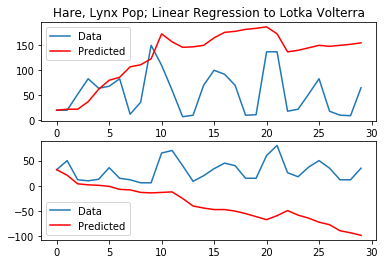

In [15]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(LRpred_lv[0,:], 'r')
axs[0].set_title('Hare, Lynx Pop; Linear Regression to Lotka Volterra')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(LRpred_lv[1,:], 'r')
axs[1].legend(['Data', 'Predicted'],loc=0)

In [16]:
Pinv_lv = np.zeros((2,2))     #THe above process is repeated now for Pseudo-inverse; all steps are analogous
Pinv_lv[:,0] = np.linalg.pinv(AH)@Hdot
Pinv_lv[:,1] = np.linalg.pinv(AL)@Ldot

In [17]:
Hdot_PI_lv = np.zeros((30))
Ldot_PI_lv = np.zeros((30))
for ii in range(30):
    Hdot_PI_lv[ii] = X[0,ii]*Pinv_lv[0,0] + prod[ii]*Pinv_lv[1,0]
    Ldot_PI_lv[ii] = X[1,ii]*Pinv_lv[0,1] + prod[ii]*Pinv_lv[1,1]

In [18]:
PIpred_lv = np.zeros((2,30))
PIpred_lv[:,0] = X[:,0]
for ii in range(29):
    PIpred_lv[0,ii+1] = PIpred_lv[0,ii] + 2*Hdot_PI_lv[ii]
    PIpred_lv[1,ii+1] = PIpred_lv[1,ii] + 2*Ldot_PI_lv[ii]
PIpred_lv = np.rint(PIpred_lv)

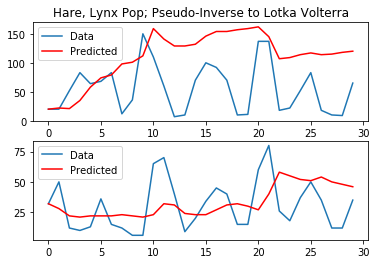

In [19]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(PIpred_lv[0,:], 'r')
axs[0].set_title('Hare, Lynx Pop; Pseudo-Inverse to Lotka Volterra')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(PIpred_lv[1,:], 'r')
axs[1].legend(['Data', 'Predicted'],loc=0)

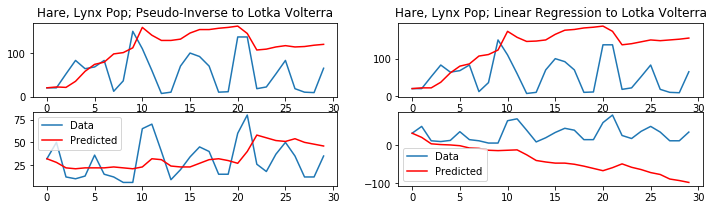

In [151]:
plt.rcParams['figure.figsize'] = [12, 3]


fig,axs = plt.subplots(2,2)

axs[0,0].plot(X[0,:])
axs[0,0].plot(PIpred_lv[0,:], 'r')
axs[0,0].set_title('Hare, Lynx Pop; Pseudo-Inverse to Lotka Volterra')
axs[1,0].plot(X[1,:])
axs[1,0].plot(PIpred_lv[1,:], 'r')
axs[1,0].legend(['Data', 'Predicted'],loc=0)
axs[0,1].plot(X[0,:])
axs[0,1].plot(LRpred_lv[0,:], 'r')
axs[0,1].set_title('Hare, Lynx Pop; Linear Regression to Lotka Volterra')
axs[1,1].plot(X[1,:])
axs[1,1].plot(LRpred_lv[1,:], 'r')
axs[1,1].legend(['Data', 'Predicted'],loc=0)

Now that we have successfully constructed differential equations models for the given population data, we would like to extend this framework to suggest models that may not have come from the Lotka-Volterra equations; instead, we would like to analyze the results of models that use sparse regressors to tell us which terms to include in our differential equations and what the coefficients on these terms should be.

In [20]:
Z0 = np.zeros((30))
Z1 = np.zeros((30))
Z2 = np.zeros((30))
S0 = np.zeros((30))
S1 = np.zeros((30))
C0 = np.zeros((30))
C1 = np.zeros((30))
for ii in range(30):
    Z0[ii] = X[0,ii]*X[1,ii]  #H*L
    Z1[ii] = X[0,ii]**2       #H^2
    Z2[ii] = X[1,ii]**2       #L^2
    S0[ii] = np.sin(X[0,ii])  #sinH
    S1[ii] = np.sin(X[1,ii])  #sinL
    C0[ii] = np.cos(X[0,ii])  #cosH
    C1[ii] = np.cos(X[1,ii])  #cosL

In [21]:
A = np.zeros((30,9))
A[:,0] = X[0,:] #Hare data
A[:,1] = X[1,:] #Lynx data
A[:,2] = Z0 
A[:,3] = Z1
A[:,4] = Z2
A[:,5] = S0
A[:,6] = S1
A[:,7] = C0
A[:,8] = C1
#for ii in range(4):
#    A[5*ii:5*(ii+1),0] = X[0,5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),1] = X[1,5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),2] = Z0[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),3] = Z1[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),4] = Z2[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),5] = S0[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),6] = S1[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),7] = C0[5*ii:5*(ii+1)]
#    A[5*ii:5*(ii+1),8] = C1[5*ii:5*(ii+1)]

B = np.zeros((30,2))
B[:,0] = Hdot
B[:,1] = Ldot
#for ii in range(4):
#    B[5*ii:5*(ii+1),0] = Hdot[5*ii:5*(ii+1)]
#    B[5*ii:5*(ii+1),1] = Ldot[5*ii:5*(ii+1)]

In [22]:
Ah = np.zeros((30,2))
Ah[:,0] = A[:,0]
Ah[:,1] = A[:,2]

Al = np.zeros((30,2))
Al[:,0] = A[:,1]
Al[:,1] = A[:,2]

In [23]:
LRcoef = np.zeros((9,2))
for ii in range(6):
    reg = linear_model.LinearRegression()    #vanilla linear regression
    reg.fit(A[5*ii:5*(ii+1),:],B[5*ii:5*(ii+1),:])
    coeff = reg.coef_.T
    LRcoef = LRcoef + coeff
LRcoef = 0.25*LRcoef


LR_lv = np.zeros((2,2))

reg = linear_model.LinearRegression()
reg.fit(Ah,B[:,0]) 
coeff = reg.coef_
LR_lv[:,0] = coeff

reg = linear_model.LinearRegression()
reg.fit(Al,B[:,0]) 
coeff = reg.coef_
LR_lv[:,1] = coeff

In [24]:
Las1coef = np.zeros((9,2))

reg = linear_model.Lasso(alpha=0.1)    #Lasso with alpha = 0.1
reg.fit(A,B)
Las1coef = reg.coef_.T

In [25]:
Las2coef = np.zeros((9,2))

reg = linear_model.Lasso(alpha=0.5)    #Lasso with alpha = 0.5
reg.fit(A,B)
Las2coef = reg.coef_.T

With coefficients in hand, we can plot the weights of each of the terms in the regressor-derived differential equations. This serves as a visual aid for understanding which terms are preferred by which regressors. In this case, the terms included in the library are listed in order: $H$, $L$, $HL$, $H^2$, $L^2$, $\sin H$, $\sin L$, $\cos H$, $\cos L$.

<BarContainer object of 9 artists>

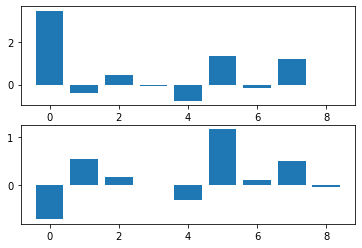

In [26]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(9),LRcoef[:,0])
axs[1].bar(range(9),LRcoef[:,1])

<BarContainer object of 9 artists>

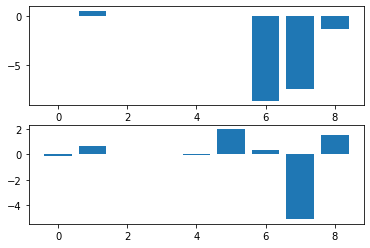

In [27]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(9),Las1coef[:,0])
axs[1].bar(range(9),Las1coef[:,1])

<BarContainer object of 9 artists>

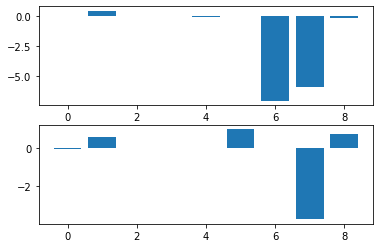

In [28]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(9),Las2coef[:,0])
axs[1].bar(range(9),Las2coef[:,1])

In [29]:
#this cell computes the derivatives of each of H and L in terms of the coefficients generated by the corresponding regressor

HdotLR = np.zeros((30))
LdotLR = np.zeros((30))
for ii in range(30):
    HdotLR[ii] = LRcoef[0,0]*X[0,ii] + LRcoef[1,0]*X[1,ii] + LRcoef[2,0]*Z0[ii] + LRcoef[3,0]*Z1[ii] + LRcoef[4,0]*Z2[ii] + LRcoef[5,0]*S0[ii] + LRcoef[6,0]*S1[ii] + LRcoef[7,0]*C0[ii] + LRcoef[8,0]*C1[ii]
    LdotLR[ii] = LRcoef[0,1]*X[0,ii] + LRcoef[1,1]*X[1,ii] + LRcoef[2,1]*Z0[ii] + LRcoef[3,1]*Z1[ii] + LRcoef[4,1]*Z2[ii] + LRcoef[5,1]*S0[ii] + LRcoef[6,1]*S1[ii] + LRcoef[7,1]*C0[ii] + LRcoef[8,1]*C1[ii]

HdotLas1 = np.zeros((30))
LdotLas1 = np.zeros((30))
for ii in range(30):
    HdotLas1[ii] = Las1coef[0,0]*X[0,ii] + Las1coef[1,0]*X[1,ii] + Las1coef[2,0]*Z0[ii] + Las1coef[3,0]*Z1[ii] + Las1coef[4,0]*Z2[ii] + Las1coef[5,0]*S0[ii] + Las1coef[6,0]*S1[ii] + Las1coef[7,0]*C0[ii] + Las1coef[8,0]*C1[ii]
    LdotLas1[ii] = Las1coef[0,1]*X[0,ii] + Las1coef[1,1]*X[1,ii] + Las1coef[2,1]*Z0[ii] + Las1coef[3,0]*Z1[ii] + Las1coef[4,1]*Z2[ii] + Las1coef[5,1]*S0[ii] + Las1coef[6,1]*S1[ii] + Las1coef[7,1]*C0[ii] + Las1coef[8,1]*C1[ii]
    
HdotLas2 = np.zeros((30))
LdotLas2 = np.zeros((30))
for ii in range(30):
    HdotLas2[ii] = Las2coef[0,0]*X[0,ii] + Las2coef[1,0]*X[1,ii] + Las2coef[2,0]*Z0[ii] + Las2coef[3,0]*Z1[ii] + Las2coef[4,0]*Z2[ii] + Las2coef[5,0]*S0[ii] + Las2coef[6,0]*S1[ii] + Las2coef[7,0]*C0[ii] + Las2coef[8,0]*C1[ii]
    LdotLas2[ii] = Las2coef[0,1]*X[0,ii] + Las2coef[1,1]*X[1,ii] + Las2coef[2,1]*Z0[ii] + Las2coef[3,1]*Z1[ii] + Las2coef[4,1]*Z2[ii] + Las2coef[5,1]*S0[ii] + Las2coef[6,1]*S1[ii] + Las2coef[7,1]*C0[ii] + Las2coef[8,1]*C1[ii]


In [30]:
LRpred = np.zeros((2,30))
LRpred[:,0] = X[:,0]
for ii in range(29):
    LRpred[0,ii+1] = LRpred[0,ii] + 2*HdotLR[ii]
    LRpred[1,ii+1] = LRpred[1,ii] + 2*LdotLR[ii]
    
Las1pred = np.zeros((2,30))                               #assembling trajectories with derivative approximations
Las1pred[:,0] = X[:,0]
for ii in range(29):
    Las1pred[0,ii+1] = Las1pred[0,ii] + 2*HdotLas1[ii]
    Las1pred[1,ii+1] = Las1pred[1,ii] + 2*LdotLas1[ii]

Las2pred = np.zeros((2,30))
Las2pred[:,0] = X[:,0]
for ii in range(29):
    Las2pred[0,ii+1] = Las2pred[0,ii] + 2*HdotLas2[ii]
    Las2pred[1,ii+1] = Las2pred[1,ii] + 2*LdotLas2[ii]


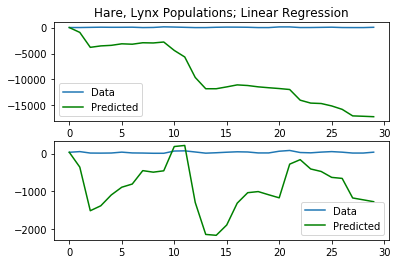

In [31]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(LRpred[0,:], 'g')
axs[0].set_title('Hare, Lynx Populations; Linear Regression')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(LRpred[1,:], 'g')
axs[1].legend(['Data', 'Predicted'],loc=0)

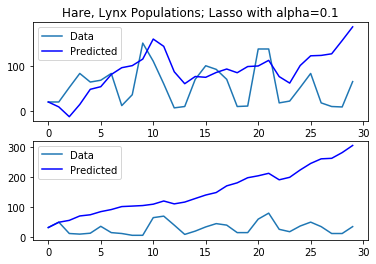

In [32]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Las1pred[0,:], 'b')
axs[0].set_title('Hare, Lynx Populations; Lasso with alpha=0.1')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(Las1pred[1,:], 'b')
axs[1].legend(['Data', 'Predicted'],loc=0)

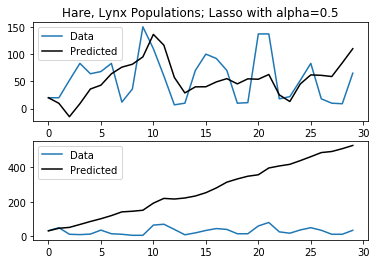

In [33]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Las2pred[0,:], 'k')
axs[0].set_title('Hare, Lynx Populations; Lasso with alpha=0.5')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(Las2pred[1,:], 'k')
axs[1].legend(['Data', 'Predicted'],loc=0)

From the graphs above, it is clear to see that none of these plots performed as well as either of the Lotka-Volterra simulations, which is not a great surprise given the fame of Lotka-Volterra as a model for predator-prey population dynamics. In particular, it is interesting to note that each of the above regressors, independent of their performance on the Hare population data, performed very poorly on the Lynx data.

We now move to time-delay DMD, for which we construct a Hankel matrix with dimension $5\times 6$. Doing a time-delay DMD analysis amounts to first taking the trajectory of a single variable and taking some subdivision of the trajectory into pieces of fixed length; once these small trajectories are obtained, they are stacked into a matrix called the Hankel matrix. The rows of the Hankel matrix are now considered as individual variables, which are analyzed and a trajectory is generated for each; finally, once this is done, the short-time trajectories are reassembled into a single trajectory for the original variable.

In [34]:
Hh = np.zeros((5,6))
for ii in range(5):           
    Hh[ii,:] = X[0,ii*6:(ii+1)*6]
                                        #construction of Hankel for both Hare and Lynx
Hl = np.zeros((5,6))                   #the original trajectory of length 30 is partitioned into 5 sub-trajectories
for ii in range(5):                    #each sub-trajectory has length 6
    Hl[ii,:] = X[1,ii*6:(ii+1)*6]

In [35]:
Uh, Sh, Vh = np.linalg.svd(Hh)
Vh = Vh.T
                                    #SVDs of Hankel matrices
Ul, Sl, Vl = np.linalg.svd(Hl)
Vl = Vl.T

In [36]:
dh = np.diag(Sh)/np.sum(np.diag(Sh))
dl = np.diag(Sl)/np.sum(np.diag(Sl))

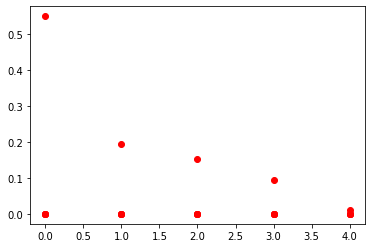

In [37]:
plt.plot(range(len(dh)), dh, 'ro')

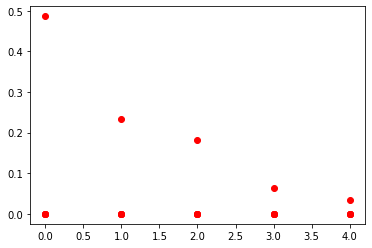

In [38]:
plt.plot(range(len(dl)), dl, 'ro')

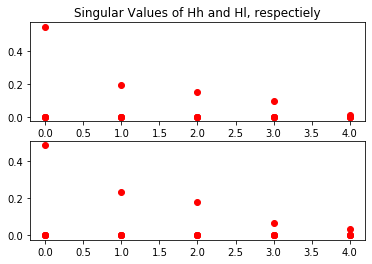

In [144]:
fig, axs = plt.subplots(2,1)

axs[0].set_title('Singular Values of Hh and Hl, respectiely')
axs[0].plot(range(len(dh)), dh, 'ro')
axs[1].plot(range(len(dl)), dl, 'ro')

Considering the above plots of singular values of the Hankel matrices, it is clear that there are likely some latent variables governing the dynamics of each of the populations; we are relieved to hear that this is seen, as the populations do depend on other variables (assuming Lotka-Volterra) and this is perhaps the first sign that we have done something right. While I am confident that the code here is solid, looking at the plots produced thus far in the document does not seem to imply much legitimacy in these methods.

At any rate, we move forward into DMD decompositions for the matrices $\texttt{Hh}$ and $\texttt{Hl}$.

In [39]:
Hh1 = Hh[:,0:5]
Hh2 = Hh[:,1:6]
Hl1 = Hl[:,0:5]
Hl2 = Hl[:,1:6]

In [40]:
#DMD for Hare Hankel
U, s, V = np.linalg.svd(Hh1)
s = 1/s; Si = np.diag(s); #V = V[0:2,:]
Atilde = U.T @ Hh2 @ V.T @ Si
lamb, Ev = np.linalg.eig(Atilde)
Phi = Hh2 @ V.T @ Si @ Ev
b = np.linalg.solve(Phi, Hh[:,0])
omega = np.log(lamb)/2
Yhh = np.zeros((5,6))
for ii in range(6):
    y = b[0]*Phi[:,0]*np.exp(omega[0]*2*ii) + b[1]*Phi[:,1]*np.exp(omega[1]*2*ii) + b[2]*Phi[:,2]*np.exp(omega[2]*2*ii) + b[3]*Phi[:,3]*np.exp(omega[3]*2*ii) + b[4]*Phi[:,4]*np.exp(omega[4]*2*ii)
    Yhh[:,ii] = y
Yh = np.zeros((30))
for ii in range(5):
    Yh[5*ii:5*ii + 6] = Yhh[ii,:]
Yh = np.rint(Yh)

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


In [41]:
#DMD for Lynx Hankel
U, s, V = np.linalg.svd(Hl1)
s = 1/s; Si = np.diag(s); #V = V[0:2,:]
Atilde = U.T @ Hl2 @ V.T @ Si
lamb, Ev = np.linalg.eig(Atilde)
Phi = Hl2 @ V.T @ Si @ Ev
b = np.linalg.solve(Phi, Hl[:,0])
omega = np.log(lamb)/2
Yll = np.zeros((5,6))
for ii in range(6):
    y = b[0]*Phi[:,0]*np.exp(omega[0]*2*ii) + b[1]*Phi[:,1]*np.exp(omega[1]*2*ii) + b[2]*Phi[:,2]*np.exp(omega[2]*2*ii) + b[3]*Phi[:,3]*np.exp(omega[3]*2*ii) + b[4]*Phi[:,4]*np.exp(omega[4]*2*ii)
    Yll[:,ii] = y
Yl = np.zeros((30))
for ii in range(5):
    Yl[5*ii:5*ii + 6] = Yll[ii,:]
Yl = np.rint(Yl)

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


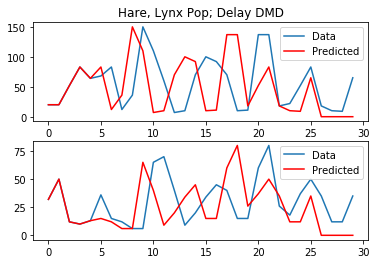

In [42]:
fig,axs = plt.subplots(2,1)

axs[0].plot(X[0,:])
axs[0].plot(Yh, 'r')
axs[0].set_title('Hare, Lynx Pop; Delay DMD')
axs[0].legend(['Data', 'Predicted'],loc=0)
axs[1].plot(X[1,:])
axs[1].plot(Yl, 'r')
axs[1].legend(['Data', 'Predicted'],loc=0)

The above plot is certainly the best-looking reproduction of trajectories obtained thus far, likely due to the fact that trajectories are more or less consttructrd piecewise, considering primarily the behavior of the variable in question during a time window considering the near future; this is reminiscent of the finite-window DMD considered previously, but here the moments of reassessment are less frequent, leading to a more parsimonious model. 

From here, we consider the best-performing models above in a formal context. In particular, we convert several of the above plots into probability distributions by ignoring tme and constructing histograms recording the number of times a particular population value is obtained in the model; once this is done, each of the histograms is renormalized to a probabilioty distribution proper. Once this is done, the distributions are compared to the distribution generated by the original data set in terms of KL-divergence. The best KL-performing distributions are then evaluated using the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

It should be noted that in the analysis below I have decided to ignore all of the non-Lotka-Volterra differential equations models and the original DMD model, seeing as it can be clearly seen from the plots that these are among the worst-performing models considered.

In [43]:
Ph = np.zeros((151))
Pl = np.zeros((151))  #distribution from data
Ph_ddmd = np.zeros((151))  #dist from delay DMD (ddmd)
Pl_ddmd = np.zeros((151))  
Ph_lvPI = np.zeros((151))  #dist from Lotka-Volterra Pseudo-Inverse (lvPI)
Pl_lvPI = np.zeros((151))
Ph_lvLR = np.zeros((151))  #dist from Lotka-Volterra Linear Regression (lvLR)
Pl_lvLR = np.zeros((151))
Ph_Y3 = np.zeros((151))  #DMD window size 3
Pl_Y3 = np.zeros((151))
Ph_Y5 = np.zeros((151))  #DMD window size 5
Pl_Y5 = np.zeros((151))

for ii in range(151):
    for jj in range(30): 
        if X[0, jj] == ii:
            Ph[ii] = Ph[ii] + 1
        if X[1, jj] == ii:
            Pl[ii] = Pl[ii] + 1
        if Yh[jj] == ii:
            Ph_ddmd[ii] = Ph_ddmd[ii] + 1
        if Yl[jj] == ii:
            Pl_ddmd[ii] = Pl_ddmd[ii] + 1
        if PIpred_lv[0, jj] == ii:
            Ph_lvPI[ii] = Ph_lvPI[ii] + 1
        if PIpred_lv[1, jj] == ii:              #create histograms for population values, recording only 0 to 150
            Pl_lvPI[ii] = Pl_lvPI[ii] + 1
        if LRpred_lv[0, jj] == ii:              #since population values are positive in real life 
            Ph_lvLR[ii] = Ph_lvLR[ii] + 1       #and none of these models predicts populations above 150
        if LRpred_lv[1, jj] == ii:              #for either species, this is in my opinion a reasonable window
            Pl_lvLR[ii] = Pl_lvLR[ii] + 1
        if Y5[0, jj] == ii:
            Ph_Y5[ii] = Ph_Y5[ii] + 1
        if Y5[1, jj] == ii:
            Pl_Y5[ii] = Pl_Y5[ii] + 1
        if Y3[0, jj] == ii:
            Ph_Y3[ii] = Ph_Y3[ii] + 1
        if Y3[1, jj] == ii:
            Pl_Y3[ii] = Pl_Y3[ii] + 1
for ii in range(151):
    if Ph[ii] == 0:
        Ph[ii] = 0.00001
    if Pl[ii] ==0:
        Pl[ii] = 0.00001
    if Ph_ddmd[ii] == 0:
        Ph_ddmd[ii] = 0.00001
    if Pl_ddmd[ii] ==0:
        Pl_ddmd[ii] = 0.00001           #if histogram reads zero, reset to small positive value
    if Ph_lvPI[ii] == 0:                #this is done for technical reasons regarding KL divergence
        Ph_lvPI[ii] = 0.00001
    if Pl_lvPI[ii] ==0:
        Pl_lvPI[ii] = 0.00001
    if Ph_lvLR[ii] == 0:
        Ph_lvLR[ii] = 0.00001
    if Pl_lvLR[ii] ==0:
        Pl_lvLR[ii] = 0.00001
    if Ph_Y3[ii] == 0:
        Ph_Y3[ii] = 0.00001
    if Pl_Y3[ii] ==0:
        Pl_Y3[ii] = 0.00001
    if Ph_Y5[ii] == 0:
        Ph_Y5[ii] = 0.00001
    if Pl_Y5[ii] ==0:
        Pl_Y5[ii] = 0.00001

In [44]:
s1 = np.sum(Ph)
Ph = Ph/s1

s2 = np.sum(Pl)
Pl = Pl/s2

s3 = np.sum(Ph_ddmd)
Ph_ddmd = Ph_ddmd/s3

s4 = np.sum(Pl_ddmd)
Pl_ddmd = Pl_ddmd/s4

s5 = np.sum(Ph_lvPI)
Ph_lvPI = Ph_lvPI/s5

s6 = np.sum(Pl_lvPI)
Pl_lvPI = Pl_lvPI/s6

s7 = np.sum(Ph_lvLR)
Ph_lvLR = Ph_lvLR/s7                      #normalize the histograms obtained above

s8 = np.sum(Pl_lvLR)
Pl_lvLR = Pl_lvLR/s8

s9 = np.sum(Ph_Y3)
Ph_Y3 = Ph_Y3/s9

s10 = np.sum(Pl_Y3)
Pl_Y3 = Pl_Y3/s10

s11 = np.sum(Ph_Y5)
Ph_Y5 = Ph_Y5/s11

s12 = np.sum(Pl_Y5)
Pl_Y5 = Pl_Y5/s12

<BarContainer object of 151 artists>

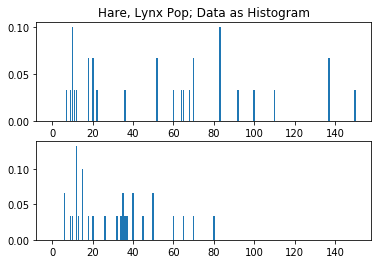

In [45]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph)
axs[0].set_title('Hare, Lynx Pop; Data as Histogram')
axs[1].bar(range(151),Pl)

<BarContainer object of 151 artists>

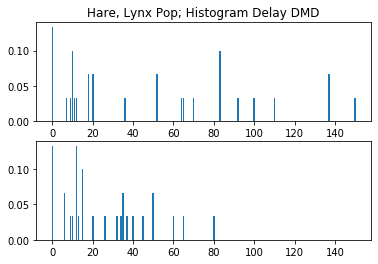

In [46]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph_ddmd)
axs[0].set_title('Hare, Lynx Pop; Histogram Delay DMD')
axs[1].bar(range(151),Pl_ddmd)

<BarContainer object of 151 artists>

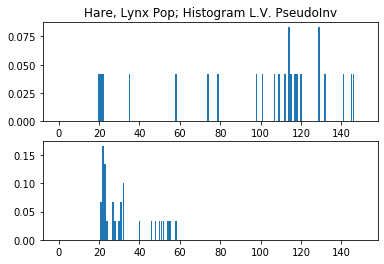

In [47]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph_lvPI)
axs[0].set_title('Hare, Lynx Pop; Histogram L.V. PseudoInv')
axs[1].bar(range(151),Pl_lvPI)

<BarContainer object of 151 artists>

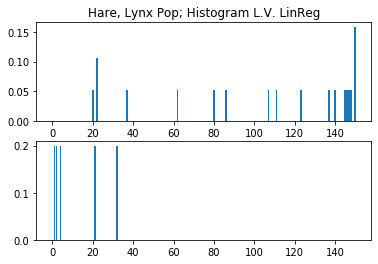

In [48]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph_lvLR)
axs[0].set_title('Hare, Lynx Pop; Histogram L.V. LinReg')
axs[1].bar(range(151),Pl_lvLR)

<BarContainer object of 151 artists>

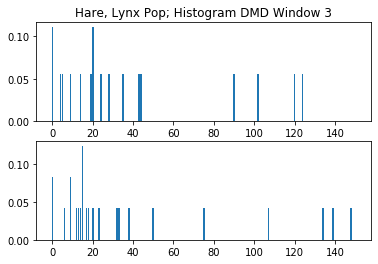

In [49]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph_Y3)
axs[0].set_title('Hare, Lynx Pop; Histogram DMD Window 3')
axs[1].bar(range(151),Pl_Y3)

<BarContainer object of 151 artists>

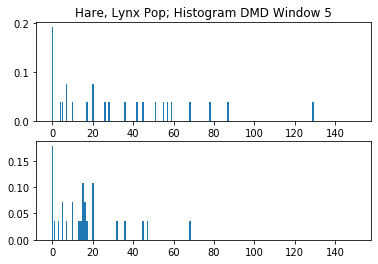

In [50]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(151),Ph_Y5)
axs[0].set_title('Hare, Lynx Pop; Histogram DMD Window 5')
axs[1].bar(range(151),Pl_Y5)

With each of these probability distributions in hand, we can now begin to evaluate them via KL-divergence from the probability distribution obtained from the data

In [51]:
KLv_ddmd = np.zeros((2,30))
for ii in range(30):
    KLv_ddmd[0,ii] = Ph_ddmd[ii]*np.log2(Ph_ddmd[ii]/Ph[ii])      #create vector consisting of summands in KL
    KLv_ddmd[1,ii] = Pl_ddmd[ii]*np.log2(Pl_ddmd[ii]/Pl[ii])

KL_ddmd = np.sum(KLv_ddmd, axis=1)          #sum the summands
print(KL_ddmd)     
print(np.average(KL_ddmd))    #KL div is assessed for Lynx pop and Hare pop, so average of two KLs is given as well

[2.48117021 2.48117011]
2.4811701595857523


In [52]:
KLv_lvPI = np.zeros((2,30))
for ii in range(30):
    KLv_lvPI[0,ii] = Ph_lvPI[ii]*np.log2(Ph_lvPI[ii]/Ph[ii])
    KLv_lvPI[1,ii] = Pl_lvPI[ii]*np.log2(Pl_lvPI[ii]/Pl[ii])

KL_lvPI = np.sum(KLv_lvPI, axis=1)
print(KL_lvPI)
print(np.average(KL_lvPI))

[0.69056472 9.09135312]
4.890958923425917


In [53]:
KLv_lvLR = np.zeros((2,30))
for ii in range(30):
    KLv_lvLR[0,ii] = Ph_lvLR[ii]*np.log2(Ph_lvLR[ii]/Ph[ii])
    KLv_lvLR[1,ii] = Pl_lvLR[ii]*np.log2(Pl_lvLR[ii]/Pl[ii])

KL_lvLR = np.sum(KLv_lvLR, axis=1)
print(KL_lvLR)
print(np.average(KL_lvLR))

[ 0.15661684 15.35073927]
7.75367805302667


In [54]:
KLv_Y3 = np.zeros((2,30))
for ii in range(30):
    KLv_Y3[0,ii] = Ph_Y3[ii]*np.log2(Ph_Y3[ii]/Ph[ii])
    KLv_Y3[1,ii] = Pl_Y3[ii]*np.log2(Pl_Y3[ii]/Pl[ii])

KL_Y3 = np.sum(KLv_Y3, axis=1)
print(KL_Y3)
print(np.average(KL_Y3))

[7.94286957 3.70298993]
5.8229297521717225


In [55]:
KLv_Y5 = np.zeros((2,30))
for ii in range(30):
    KLv_Y5[0,ii] = Ph_Y5[ii]*np.log2(Ph_Y5[ii]/Ph[ii])
    KLv_Y5[1,ii] = Pl_Y5[ii]*np.log2(Pl_Y5[ii]/Pl[ii])

KL_Y5 = np.sum(KLv_Y5, axis=1)
print(KL_Y5)
print(np.average(KL_Y5))

[6.96952946 9.18483981]
8.077184638694408


From the above listed KL-divergence values for each of the prediction curves, it is not entirely obvious which of these models is the best; in several cases, a particular model performed well in the KL sense for one of the populations but performed poorly for the other. Because of this, we do not discard any of the models and instead consider the AIC and BIC scores of each. We now compare the AIC and BIC scores of the models, evaluating for each of the three their Hare and Lynx populations separately. This is first done for the AIC score:

In [56]:
AIC_lvLR = np.zeros((2))
RSS = np.linalg.norm(LRpred_lv[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_lvLR[0] = 8 - 2*lnL
RSS = np.linalg.norm(LRpred_lv[1,:] - X[1,:], 2)**2      #lvLR and lvPI both use 4 parameters, as seen in LV equations
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_lvLR[1] = 8 - 2*lnL
print(AIC_lvLR)

[255.89618959 244.64725237]


In [57]:
AIC_lvPI = np.zeros((2))
RSS = np.linalg.norm(PIpred_lv[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_lvPI[0] = 8 - 2*lnL
RSS = np.linalg.norm(PIpred_lv[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_lvPI[1] = 8 - 2*lnL
print(AIC_lvPI)

[242.33277936 168.7488641 ]


In [58]:
Y_ddmd = np.zeros((2,30))
Y_ddmd[0,:] = Yh
Y_ddmd[1,:] = Yl

AIC_ddmd = np.zeros((2))
RSS = np.linalg.norm(Y_ddmd[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_ddmd[0] = 20 - 2*lnL                                   #ddmd uses 5 parameters for each of Hare, Lynx
RSS = np.linalg.norm(Y_ddmd[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_ddmd[1] = 20 - 2*lnL
print(AIC_ddmd)

[237.79743053 191.54430281]


In [59]:
AIC_Y3 = np.zeros((2))
RSS = np.linalg.norm(Y3[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_Y3[0] = 108 - 2*lnL                                   #dmd window 3 uses 2 parameters for each of 27 times
RSS = np.linalg.norm(Y3[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_Y3[1] = 108 - 2*lnL
print(AIC_Y3)

[393.21586052 321.99591531]


In [60]:
AIC_Y5 = np.zeros((2))
RSS = np.linalg.norm(Y5[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_Y5[0] = 96 - 2*lnL                                   #dmd window 5 uses 2 parameters for each of 24 times
RSS = np.linalg.norm(Y5[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
AIC_Y5[1] = 96 - 2*lnL
print(AIC_Y5)

[326.17619654 277.42181979]


We now evaluate the BIC score of each of the models:

In [61]:
BIC_lvLR = np.zeros((2))
RSS = np.linalg.norm(LRpred_lv[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_lvLR[0] = 4*np.log(30) - 2*lnL
RSS = np.linalg.norm(LRpred_lv[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_lvLR[1] = 4*np.log(30) - 2*lnL
print(BIC_lvLR)

[261.50097912 250.25204189]


In [62]:
BIC_lvPI = np.zeros((2))
RSS = np.linalg.norm(PIpred_lv[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_lvPI[0] = 4*np.log(30) - 2*lnL
RSS = np.linalg.norm(PIpred_lv[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_lvPI[1] = 4*np.log(30) - 2*lnL
print(BIC_lvPI)

[247.93756889 174.35365362]


In [63]:
BIC_ddmd = np.zeros((2))
RSS = np.linalg.norm(Y_ddmd[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_ddmd[0] = 10*np.log(30) - 2*lnL                                   #ddmd uses 5 parameters for each of Hare, Lynx
RSS = np.linalg.norm(Y_ddmd[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_ddmd[1] = 10*np.log(30) - 2*lnL
print(BIC_ddmd)

[251.80940435 205.55627662]


In [64]:
BIC_Y3 = np.zeros((2))
RSS = np.linalg.norm(Y3[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_Y3[0] = 48*np.log(30) - 2*lnL                                   #ddmd uses 5 parameters for each of Hare, Lynx
RSS = np.linalg.norm(Y3[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_Y3[1] = 48*np.log(30) - 2*lnL
print(BIC_Y3)

[448.47333484 377.25338963]


In [65]:
BIC_Y5 = np.zeros((2))
RSS = np.linalg.norm(Y5[0,:] - X[0,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_Y5[0] = 54*np.log(30) - 2*lnL                                   #ddmd uses 5 parameters for each of Hare, Lynx
RSS = np.linalg.norm(Y5[1,:] - X[1,:], 2)**2
sigsq = RSS/30
lnL = 15*np.log(2*np.pi) - 15*np.log(sigsq) - 15
BIC_Y5[1] = 54*np.log(30) - 2*lnL
print(BIC_Y5)

[413.84085515 365.0864784 ]


To facilitate the analysis and comparison of the KL, AIC, and BIC scores listed above, consider the plots of each below; recall that 5 distributions are analyzed with each of these metrics: Linear Regression, pseudo-Inverse, Delay DMD, DMD window size 3, and DMD window size 5. The scores of each are listed belos in that order (left to right)

<BarContainer object of 5 artists>

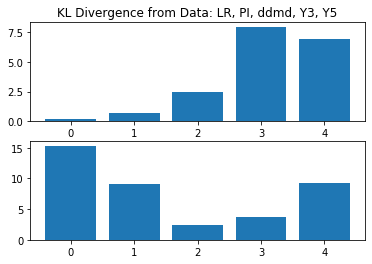

In [66]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(5),np.array([KL_lvLR[0], KL_lvPI[0], KL_ddmd[0], KL_Y3[0], KL_Y5[0]]))
axs[0].set_title('KL Divergence from Data: LR, PI, ddmd, Y3, Y5')
axs[1].bar(range(5),np.array([KL_lvLR[1], KL_lvPI[1], KL_ddmd[1], KL_Y3[1], KL_Y5[1]]))

The above plot clearly illustrates the discordance in KL scores of the models between the two populations; for example, Linear Regression performs remarkably well on the Hare data while it fails miserably on the Lynx data. Similarly, the DMD with window size 3 performs quite poorly on Hare populations, while it predicts Lynx fluctuations rather well. That said, it is worth noting that the window size 3 DMD model did predict some negative population values, which is unrealistic and not reflected in any of these metrics (negative populations are not recorded in constructing histograms, so $\texttt{Y3}$ actually did even worse than it seems).

However, from the above it seems that Delay DMD is the best performing model, which matches with our intuition from observing the plot of Delay DMD itself.

<BarContainer object of 5 artists>

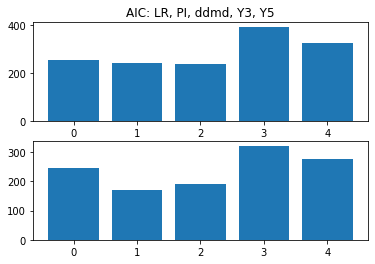

In [67]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(5),np.array([AIC_lvLR[0], AIC_lvPI[0], AIC_ddmd[0], AIC_Y3[0], AIC_Y5[0]]))
axs[0].set_title('AIC: LR, PI, ddmd, Y3, Y5')
axs[1].bar(range(5),np.array([AIC_lvLR[1], AIC_lvPI[1], AIC_ddmd[1], AIC_Y3[1], AIC_Y5[1]]))

<BarContainer object of 5 artists>

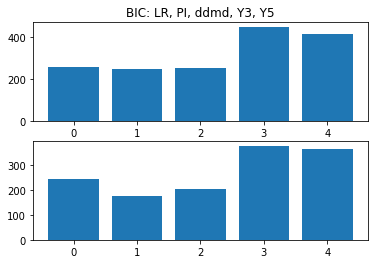

In [68]:
fig,axs = plt.subplots(2,1)

axs[0].bar(range(5),np.array([AIC_lvLR[0], BIC_lvPI[0], BIC_ddmd[0], BIC_Y3[0], BIC_Y5[0]]))
axs[0].set_title('BIC: LR, PI, ddmd, Y3, Y5')
axs[1].bar(range(5),np.array([AIC_lvLR[1], BIC_lvPI[1], BIC_ddmd[1], BIC_Y3[1], BIC_Y5[1]]))

<BarContainer object of 5 artists>

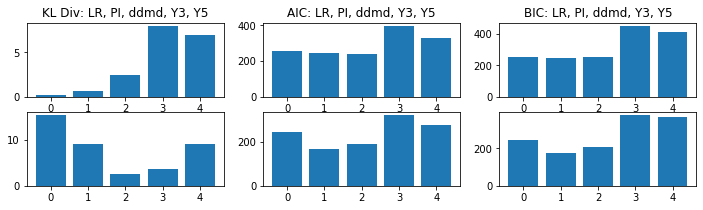

In [153]:
plt.rcParams['figure.figsize'] = [12, 3]


fig,axs = plt.subplots(2,3)

axs[0,0].bar(range(5),np.array([KL_lvLR[0], KL_lvPI[0], KL_ddmd[0], KL_Y3[0], KL_Y5[0]]))
axs[0,0].set_title('KL Div: LR, PI, ddmd, Y3, Y5')
axs[1,0].bar(range(5),np.array([KL_lvLR[1], KL_lvPI[1], KL_ddmd[1], KL_Y3[1], KL_Y5[1]]))
axs[0,1].bar(range(5),np.array([AIC_lvLR[0], AIC_lvPI[0], AIC_ddmd[0], AIC_Y3[0], AIC_Y5[0]]))
axs[0,1].set_title('AIC: LR, PI, ddmd, Y3, Y5')
axs[1,1].bar(range(5),np.array([AIC_lvLR[1], AIC_lvPI[1], AIC_ddmd[1], AIC_Y3[1], AIC_Y5[1]]))
axs[0,2].bar(range(5),np.array([AIC_lvLR[0], BIC_lvPI[0], BIC_ddmd[0], BIC_Y3[0], BIC_Y5[0]]))
axs[0,2].set_title('BIC: LR, PI, ddmd, Y3, Y5')
axs[1,2].bar(range(5),np.array([AIC_lvLR[1], BIC_lvPI[1], BIC_ddmd[1], BIC_Y3[1], BIC_Y5[1]]))

In each of the AIC and BIC plots above, it is apparent that Delay DMD is the best-performing model on this data, which is rather counter to our intuition given that predator-prey populations are assumed to fluctuate around solutions of the Lotka-Volterra differential equations. In this case, the poor performance of the inferred Lotka-Volterra equations may be a result of poor choice of regressors or an uninformative or noisy data set. We may never know.

We now move on to the Belousov-Zhabotinsky chemical oscillator data; we first import the data itself and observe the first two images in the data set to get a sense of what sorts of images we hopw to reproduce. Following this, we attempt to construct accurate reproductions of these images using a DMD framework; this is done with mixed results.

In [69]:
filepath = 'BZ.mat'
BZ = {}
f = h5py.File(filepath)
for k, v in f.items():
    BZ[k] = np.array(v)
BZ = BZ['BZ_tensor']

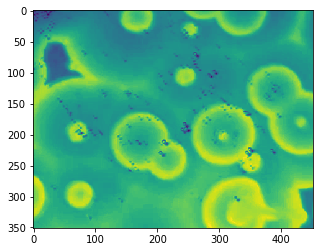

In [70]:
first = BZ[0,:,:]
plt.imshow(first.T)

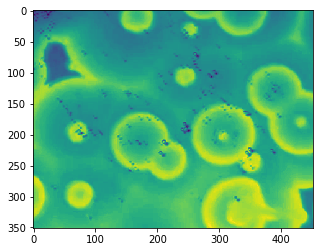

In [71]:
second = BZ[1,:,:]
plt.imshow(second.T)

Now that we have a sense of what we are aiming for, we will perform the first steps of the DMD decomposition and assessing how much of a rank reduction we can expect to use while maintaining a semblance of accuracy. To do this, we perform an SVD decomposition of the $\texttt{C1}$ matrix used in the DMD and plot the singular values of this matrix.

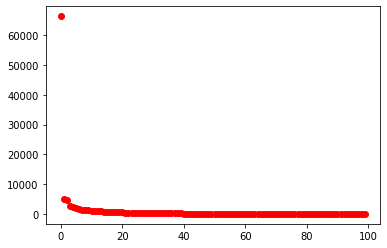

In [72]:
C1 = BZ[0:1199, :, 0]
C1 = C1.T
C2 = BZ[1:1200, :, 0]
C2 = C2.T
U, s, V = np.linalg.svd(C1)

plt.plot(range(100), s[0:100], 'ro')

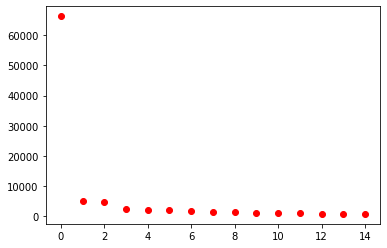

In [73]:
plt.plot(range(15), s[0:15], 'ro')

With this in hand, we see that the singular values drop off considerably after the first and drop off again around 20 and 40. We thus decide to use the top 40 singular values.

In [74]:
C1 = BZ[0:1199, :, 0]
C1 = C1.T
C2 = BZ[1:1200, :, 0]
C2 = C2.T
U, s, V = np.linalg.svd(C1)
s = s[0:40] ; si = 1/s ; Si = np.diag(si) ; U = U[:, 0:40] ; V = V[:, 0:40]
Atilde = U.T @ C2 @ V @ Si
lamb, Ev = np.linalg.eig(Atilde)
Lamb = np.diag(lamb)
Phi = C2 @ V @ Si @ Ev
b = np.linalg.pinv(Phi) @ C1[:, 0]

In [75]:
BZ_dmd = np.zeros((451,1200))
for ii in range(1199):
    BZ_dmd[:,ii+1] = Phi @ np.linalg.matrix_power(Lamb, ii) @ b
BZ_dmd = BZ_dmd.T

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


As a preliminary step, we check the 2-norm of the difference between the prediction matrix $\texttt{BZ_dmd}$ and the $0$th slice of the tensor $\texttt{BZ}$:

In [76]:
np.linalg.norm(BZ_dmd - BZ[:,:,0], ord=2)

66291.66787509847

This is a bad sign. Nevertheless, this is not sufficient to create an image to compare with the true image in the Belousov-Zhabotinsky data set. Indeed, the matrix $\texttt{BZ_dmd}$ is the 0th slice of a prediction matrix that contains the trajectories of all pixels in the image. Put otherwise, the 0th column of the matrix $\texttt{BZ_dmd}$ contains the values of only the pixels in the 0th column of the 0th image that would be produced; the 1st column of the matrix $\texttt{BZ_dmd}$ contains the values of only the pixels in the 0th column of the 1st image that would be produced. That is, we need to repeat this process for all 351 distinct 451 by 1200 slices of the DMD-predicted trajectory; this is done below:

In [77]:
BZ_dmd_full = np.zeros((1200,451,351))

In [78]:
for jj in range(351):
    C1 = BZ[0:1199, :, jj]
    C1 = C1.T
    C2 = BZ[1:1200, :, jj]
    C2 = C2.T
    U, s, V = np.linalg.svd(C1)
    s = s[0:40] ; si = 1/s ; Si = np.diag(si) ; U = U[:, 0:40] ; V = V[:, 0:40]
    Atilde = U.T @ C2 @ V @ Si
    lamb, Ev = np.linalg.eig(Atilde)
    Lamb = np.diag(lamb)
    Phi = C2 @ V @ Si @ Ev
    b = np.linalg.pinv(Phi) @ C1[:, 0]
    
    BZ_dummy = np.zeros((451,1200))
    BZ_dummy[:,0] = Phi @ b
    for ii in range(1199):
        BZ_dummy[:,ii+1] = Phi @ np.linalg.matrix_power(Lamb, ii) @ b
    BZ_dummy = BZ_dummy.T
    BZ_dmd_full[:,:,jj] = BZ_dummy

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


To evaluate the performance of this method, we observe the 0th, 1st, and 2nd images that have been produced by the DMD process. Considering the images below, it is clear that we need some other kind of approach.

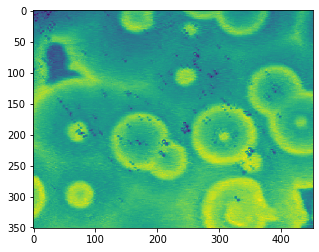

In [79]:
zeroy = BZ_dmd_full[0,:,:]
firsty = BZ_dmd_full[1,:,:]
secondy = BZ_dmd_full[2,:,:]
thirdy = BZ_dmd_full[3,:,:]
plt.imshow(zeroy.T)

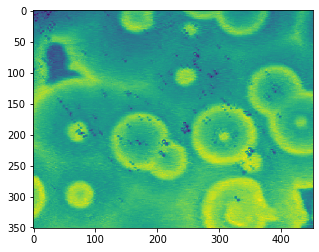

In [80]:
plt.imshow(firsty.T)

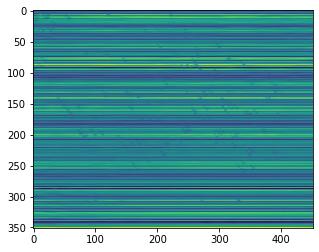

In [81]:
plt.imshow(secondy.T)

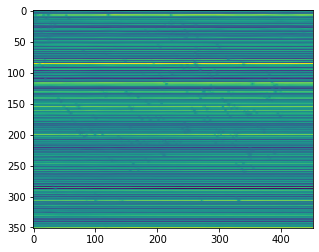

In [82]:
plt.imshow(thirdy.T)

In an effort to remedy this, we now consider the sliding-window approach that yielded the predictions $\texttt{Y3}$ and $\texttt{Y5}$ in the Hare/Lynx data set above. Doing so in this context produces a prediction tensor for the Belousov-Zhabotinsky images based on the corresponding given images and the 4 images that follow it; that is, we will here use a sliding window of length 5  to produce a prediction. Subsequently, we do the same for a length 3 window and compare performance. To save computational time, this is used to produce only the first 21 images of the trajectory predicted.

For some reason, this yields values that are both positive and negative, but more or less the appropriate magnitude; taking the absolute value of all entries and producing images from there, we obtain images that aren't $\textit{too}$ terrible. These images are produced beneath the code.

In [83]:
for jj in range(351):
    BZ_dummy = np.zeros((451,1200))
    for kk in range(21):
        C1 = BZ[kk:kk+5, :, jj]
        C1 = C1.T
        C2 = BZ[kk+1:kk+6, :, jj]
        C2 = C2.T
        U, s, V = np.linalg.svd(C1)
        s = s[0:40] ; si = 1/s ; Si = np.diag(si) ; U = U[:, 0:5] ; V = V[:, 0:40]  #window size 5 
        Atilde = U.T @ C2 @ V @ Si
        lamb, Ev = np.linalg.eig(Atilde)
        Lamb = np.diag(lamb)
        Phi = C2 @ V @ Si @ Ev
        b = np.linalg.pinv(Phi) @ C1[:, 0]
        BZ_dummy[:,kk] = np.absolute(Phi @ Lamb @ b)
    BZ_dummy = BZ_dummy.T
    BZ_dmd_full[:,:,jj] = BZ_dummy

Before considering the images, observe a few of the entries of $\texttt{BZ_dmd_full}$ in comparison to the corresponding entries of $\texttt{BZ}$; this quick check assures us that the values are of the appropriate order.

In [84]:
print(BZ_dmd_full[0:10,0:5,0])
print(BZ[0:10,0:5,0])

[[ 43.30645767  44.89438557  44.89438557  42.25513741  39.18055468]
 [ 99.54661247 101.96129045 101.96129045  95.8553867   88.98439894]
 [ 70.67217023  72.58977853  72.58977853  68.15014735  63.35107945]
 [  6.91793442   6.70398108   6.70398108   5.88057492   5.85074713]
 [ 61.84474188  61.91345679  61.91345679  56.91252544  54.03356229]
 [  6.72858384   5.90847173   5.90847173   4.75865378   5.15648442]
 [ 36.74138572  35.91161107  35.91161107  33.29985754  31.34104239]
 [ 40.38204421  40.5859917   40.80816221  38.07862424  35.42050185]
 [ 47.92988044  47.40446089  45.88742937  41.41000791  40.77887474]
 [ 88.33358915  88.44558735  87.60585303  80.9009137   76.49933735]]
[[54. 55. 55. 52. 48.]
 [54. 55. 55. 52. 48.]
 [54. 55. 55. 52. 48.]
 [54. 55. 55. 52. 48.]
 [54. 55. 55. 51. 48.]
 [53. 55. 55. 52. 48.]
 [53. 55. 55. 52. 48.]
 [54. 55. 55. 51. 48.]
 [54. 55. 55. 51. 48.]
 [55. 55. 55. 51. 48.]]


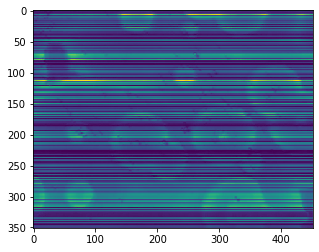

In [85]:
zeroy = BZ_dmd_full[0,:,:]
firsty = BZ_dmd_full[1,:,:]
secondy = BZ_dmd_full[2,:,:]
plt.imshow(zeroy.T)

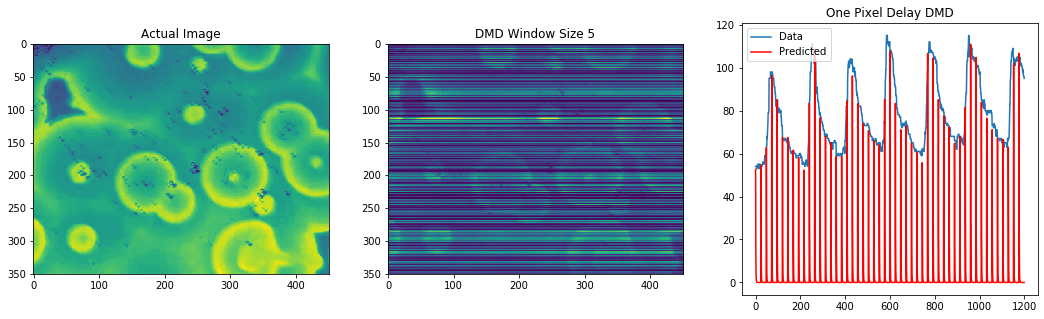

In [179]:
plt.rcParams['figure.figsize'] = [18, 5]

fig, axs = plt.subplots(1,3)

axs[0].imshow(first.T)
axs[0].set_title('Actual Image')
axs[1].imshow(zeroy.T)
axs[1].set_title('DMD Window Size 5')
axs[2].plot(BZ[:,0,0])
axs[2].plot(x_ddmd, 'r')
axs[2].set_title('One Pixel Delay DMD')
axs[2].legend(['Data', 'Predicted'],loc=0)

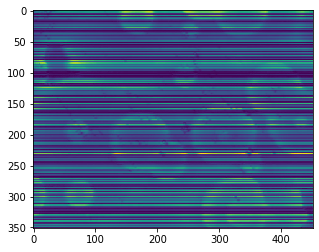

In [86]:
plt.imshow(firsty.T)

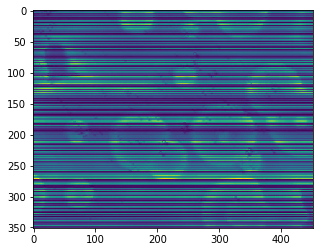

In [87]:
plt.imshow(secondy.T)

Compare the above images with the images given in the $\texttt{BZ}$ data set:

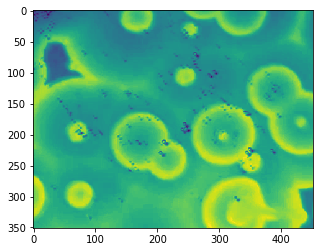

In [88]:
plt.imshow(BZ[0,:,:].T)

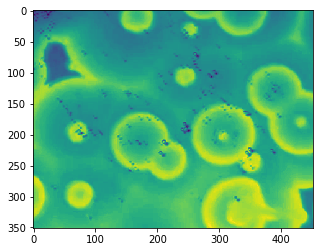

In [89]:
plt.imshow(BZ[1,:,:].T)

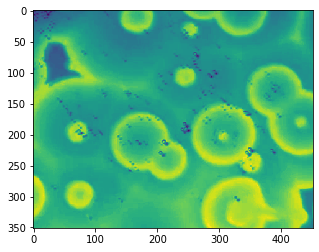

In [90]:
plt.imshow(BZ[2,:,:].T)

In [91]:
BZ_dmd_fullw3 = np.zeros((1200, 451, 351))

for jj in range(351):
    BZ_dummy = np.zeros((451,1200))
    for kk in range(21):
        C1 = BZ[kk:kk+3, :, jj]
        C1 = C1.T
        C2 = BZ[kk+1:kk+4, :, jj]
        C2 = C2.T
        U, s, V = np.linalg.svd(C1)
        s = s[0:10] ; si = 1/s ; Si = np.diag(si) ; U = U[:, 0:3] ; V = V[:, 0:10]  #top 3 singular values
        Atilde = U.T @ C2 @ V @ Si
        lamb, Ev = np.linalg.eig(Atilde)
        Lamb = np.diag(lamb)
        Phi = C2 @ V @ Si @ Ev
        b = np.linalg.pinv(Phi) @ C1[:, 0]
        BZ_dummy[:,kk] = np.absolute(Phi @ Lamb @ b)
    BZ_dummy = BZ_dummy.T
    BZ_dmd_fullw3[:,:,jj] = BZ_dummy

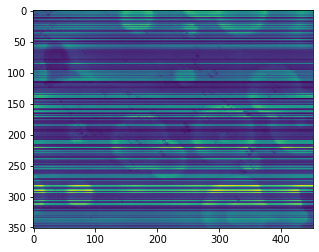

In [92]:
zero3 = BZ_dmd_fullw3[0,:,:]
first3 = BZ_dmd_fullw3[1,:,:]
second3 = BZ_dmd_fullw3[2,:,:]
plt.imshow(zero3.T)

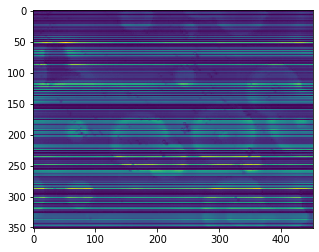

In [93]:
plt.imshow(first3.T)

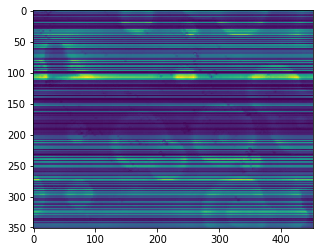

In [94]:
plt.imshow(second3.T)

In [123]:
x = BZ[:,0,0]
Hx = np.zeros((50,24))
for ii in range(50):
    Hx[ii,:] = x[ii*24:ii*24+24]
H1 = Hx[:,0:23]
H2 = Hx[:,1:24]
Ux, sx, Vx = np.linalg.svd(H1)
sx.shape

(23,)

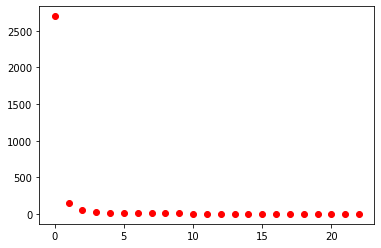

In [124]:
plt.plot(range(23),sx, 'ro')

In [139]:
sx = sx[0:5] ; si = 1/sx ; Si = np.diag(si) ; Ux = Ux[:, 0:5] ; Vx = Vx[:, 0:5]
Atild = Ux.T @ H2 @ Vx @ Si
lam, E = np.linalg.eig(Atild)
phi = H2 @ Vx @ Si @ Ev
b0 = np.linalg.pinv(phi) @ H1[:, 0]
Lam = np.diag(lam)

In [140]:
x_ddmd = np.zeros((1200))
Hx_pred = np.zeros((50,24))
Hx_pred[:,0] = phi @ b0
for jj in range(24):
    Hx_pred[:, jj] = phi @ np.linalg.matrix_power(Lam, jj) @ b0
for ii in range(50):
    x_ddmd[ii*24:ii*24+24] = Hx_pred[ii,:]

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


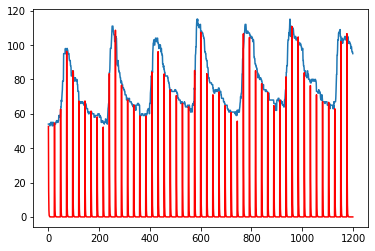

In [141]:
plt.plot(BZ[:,0,0])
plt.plot(x_ddmd, 'r')

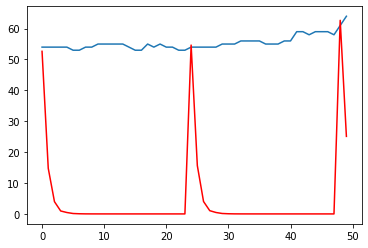

In [128]:
plt.plot(BZ[0:50,0,0])
plt.plot(x_ddmd[0:50], 'r')

In [130]:
BZ_ddmd = np.zeros((1200, 451, 351))

for kk in range(451):
    for ll in range(351):
        xd = BZ[:,kk,ll]
        Hxd = np.zeros((50,24))
        for ii in range(50):
            Hxd[ii,:] = xd[ii*24:ii*24+24]
        H1d = Hxd[:,0:23]
        H2d = Hxd[:,1:24]
        Ud, sd, Vd = np.linalg.svd(H1d)
        sd = sd[0:5] ; si = 1/sd ; Si = np.diag(si) ; Ud = Ud[:, 0:5] ; Vd = Vd[:, 0:5]
        Atilded = Ud.T @ H2d @ Vd @ Si
        lambd, Evd = np.linalg.eig(Atilded)
        Phid = H2d @ Vd @ Si @ Evd
        bd = np.linalg.pinv(Phid) @ H1d[:, 0]
        Lambd = np.diag(lambd)
        xd_ddmd = np.zeros((1200))
        Hxd_pred = np.zeros((50,24))
        Hxd_pred[:,0] = Phid @ bd
        for jj in range(24):
            Hxd_pred[:, jj] = Phid @ np.linalg.matrix_power(Lambd, jj) @ bd
        for ii in range(50):
            xd_ddmd[ii*24:ii*24+24] = Hxd_pred[ii,:]
        BZ_ddmd[:,kk,ll] = xd_ddmd

/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/cameronwright/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


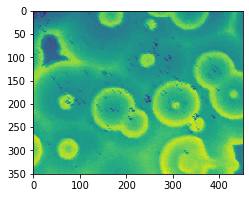

In [160]:
p0 = BZ_ddmd[0,:,:]
p1 = BZ_ddmd[1,:,:]
p2 = BZ_ddmd[2,:,:]
p23 = BZ_ddmd[23,:,:]
p24 = BZ_ddmd[24,:,:]
p25 = BZ_ddmd[25,:,:]
plt.imshow(p0.T)

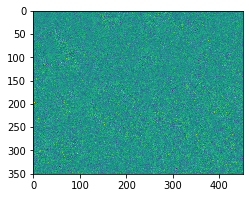

In [161]:
plt.imshow(p1.T)

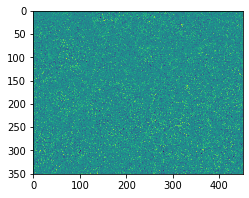

In [162]:
plt.imshow(p2.T)

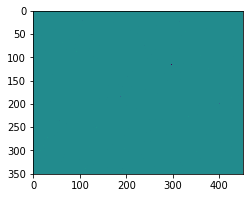

In [163]:
plt.imshow(p23.T)

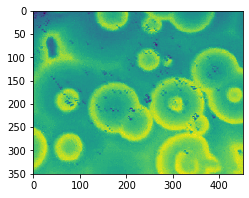

In [164]:
plt.imshow(p24.T)

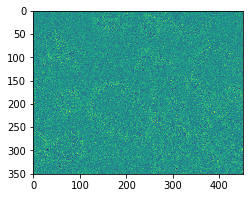

In [165]:
plt.imshow(p25.T)